# Tutorial 4: Comparison between TensorFlow and PytorchGeometric on the SchNet Arquitecture

## Pytorch Geometric 

In [ ]:
!pip install torch_geometric
# Pyg cpu libraries
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html

In [ ]:
import argparse
import os.path as osp
import numpy as np
import torch
from tqdm import tqdm
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SchNet
import torch.nn as nn

In [ ]:
path = '/content/qm9/'
dataset = QM9(path)

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: QM9(130831):
Number of graphs: 130831
Number of features: 11
Number of classes: 19


De forma grafica se muestra una molecula del dataset, en este caso la que esta en el indice 121.



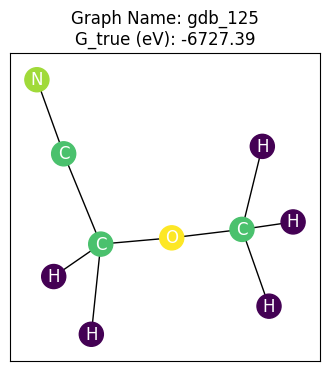

In [ ]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
atomic_symbols = {
    1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 10: 'Ne',
    11: 'Na', 12: 'Mg', 13: 'Al', 14: 'Si', 15: 'P', 16: 'S', 17: 'Cl', 18: 'Ar',
    19: 'K', 20: 'Ca'
}
data = dataset[121]
def visualize_graph(G, data, node_labels):
    plt.figure(figsize=(4,4))
    plt.xticks([])
    plt.yticks([])
    node_colors = data.x.numpy()[:, 5]

    pos = nx.spring_layout(G, seed=42)
    nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=42), node_color=node_colors)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_color='white')
    plt.title(f"Graph Name: {data.name}\nG_true (eV): {np.round(data.y.numpy()[0,10], 2):.2f}")
    plt.show()

# Convertir el gráfico a NetworkX
G = to_networkx(data, to_undirected=True)
# Crear etiquetas para los nodos (usando el número atómico en este caso)
node_labels = {i: atomic_symbols.get(int(data.x[i, 5].item()), '?') for i in range(data.num_nodes)}

visualize_graph(G, data, node_labels)

In [ ]:
path = '/content/qm9/'
dataset = QM9(path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset, val_dataset, test_dataset = dataset[:3000], dataset[3000:4000], dataset[4000:5000]
target_mean, target_std = train_dataset.mean(target=10), train_dataset.std(target=10)
net = SchNet(
            hidden_channels=64, #embedding layer
            num_filters=64, #channels
            num_interactions=3, #capas de interaccion
            num_gaussians=300,
            cutoff=30.0,
            atomref=dataset.atomref(target=10),
            mean = target_mean,
            std = target_std
        )
dataset.to(device)
model = net.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-3)
loss_mse = nn.MSELoss(reduction='mean')
loss_mae = nn.L1Loss()

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True) #before 100
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=True) #before 100

def train(data):
      model.train()
      for idx, batch in enumerate(data):  # Iterate over each mini-batch.
          out = model.forward(batch.z, batch.pos, batch.batch) # Perform a single forward pass.
          loss = loss_mse(out, batch.y[:,10, np.newaxis])  # Compute the loss solely based on the training nodes.
          loss2 = loss_mae(out, batch.y[:,10, np.newaxis])
          loss.backward()  # Derive gradients.
          optimizer.step()  # Update parameters based on gradients.
          optimizer.zero_grad()  # Clear gradients.
      return loss, loss2

def test(data):
      model.eval()
      for idx, batch in enumerate(data):  # Iterate over each mini-batch.
          out = model.forward(batch.z, batch.pos, batch.batch) # Perform a single forward pass.
          loss = loss_mse(out, batch.y[:,10, np.newaxis])  # Compute the loss solely based on the training nodes.
          loss2 = loss_mae(out, batch.y[:,10, np.newaxis])
      return loss, loss2

history = {}
history['train_mse'] = []
history['val_mse'] = []
for epoch in range(1, 51):
    loss_train, loss2_train = train(train_loader)
    loss_val, loss2_val = test(val_loader)
    history['train_mse'].append(loss_train)
    history['val_mse'].append(loss_val)

    print(f'Epoch: {epoch:03d}, Train(MSE): {loss_train:.2e}, Val(MSE): {loss_val:.2e}')

Epoch: 001, Train(MSE): 3.64e+09, Val(MSE): 1.72e+09
Epoch: 002, Train(MSE): 1.21e+09, Val(MSE): 5.81e+08
Epoch: 003, Train(MSE): 8.12e+08, Val(MSE): 6.57e+08
Epoch: 004, Train(MSE): 1.52e+08, Val(MSE): 2.81e+08
Epoch: 005, Train(MSE): 1.62e+08, Val(MSE): 1.44e+08
Epoch: 006, Train(MSE): 1.71e+08, Val(MSE): 1.13e+08
Epoch: 007, Train(MSE): 5.08e+07, Val(MSE): 9.48e+07
Epoch: 008, Train(MSE): 3.62e+07, Val(MSE): 4.23e+07
Epoch: 009, Train(MSE): 4.48e+07, Val(MSE): 2.82e+07
Epoch: 010, Train(MSE): 3.61e+07, Val(MSE): 4.48e+07
Epoch: 011, Train(MSE): 2.81e+07, Val(MSE): 1.32e+07
Epoch: 012, Train(MSE): 1.95e+07, Val(MSE): 3.20e+07
Epoch: 013, Train(MSE): 1.44e+07, Val(MSE): 1.39e+07
Epoch: 014, Train(MSE): 1.44e+07, Val(MSE): 1.79e+07
Epoch: 015, Train(MSE): 1.43e+07, Val(MSE): 2.10e+07
Epoch: 016, Train(MSE): 1.23e+07, Val(MSE): 1.07e+07
Epoch: 017, Train(MSE): 1.22e+07, Val(MSE): 8.53e+06
Epoch: 018, Train(MSE): 1.24e+07, Val(MSE): 7.22e+06
Epoch: 019, Train(MSE): 1.08e+07, Val(MSE): 8.

In [ ]:
print(f' MAE (train) {loss2_train:.2f}, MAE (val) {loss2_val:.2f}')

 MAE (train) 925.78, MAE (val) 893.82


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True) #before 100
loss_test, loss2_test = test(test_loader)
print(f' MSE (test) {loss_test:.2e}, MAE (test) {loss2_test:.2f}')

 MSE (test) 1.75e+06, MAE (test) 976.36


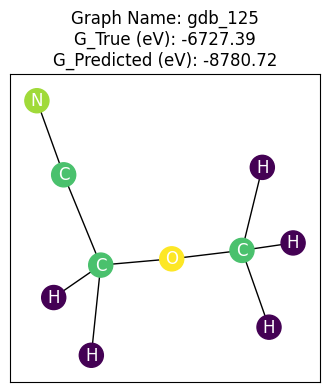

In [ ]:
##Testeo
data = dataset[121]
model.eval()
# Convertir el gráfico a NetworkX
G = to_networkx(data, to_undirected=True)
# Crear etiquetas para los nodos (usando el número atómico en este caso)
node_labels = {i: atomic_symbols.get(int(data.x[i, 5].item()), '?') for i in range(data.num_nodes)}
# Crear etiquetas para los nodos (usando el número atómico en este caso)
plt.figure(figsize=(4,4))
plt.xticks([])
plt.yticks([])
node_colors = data.x.numpy()[:, 5]

pos = nx.spring_layout(G, seed=42)
nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=42), node_color=node_colors)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_color='white')
plt.title(f"Graph Name: {data.name}\nG_True (eV): {np.round(data.y.numpy()[0,10], 2):.2f}\nG_Predicted (eV): {np.round(model.forward(data.z, data.pos)[0][0].detach().numpy(), 2):.2f}")
plt.show()


  Como es visible falta seguir un entrenamiento con mas datos dentro de la red, para asi lograr una red con mayor capacidad de generalizacion en el testeo

## TensorFlow 